<a href="https://colab.research.google.com/github/Oreolorun/NeuralNetsPractice/blob/main/GAN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd

In [2]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [4]:
#  loading dataset
dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/upscale_data.npy', allow_pickle=True)
dataset = [x[1] for x in dataset]
print('\nDone!')


Done!


In [5]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx]/255
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
      image = image.type(torch.float32)
    return image

In [6]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(dataset, transforms=transforms.ToTensor())

#  creating dataloader
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [7]:
for batch in train_dl:
  print(batch.size())
  break

torch.Size([32, 1, 100, 100])


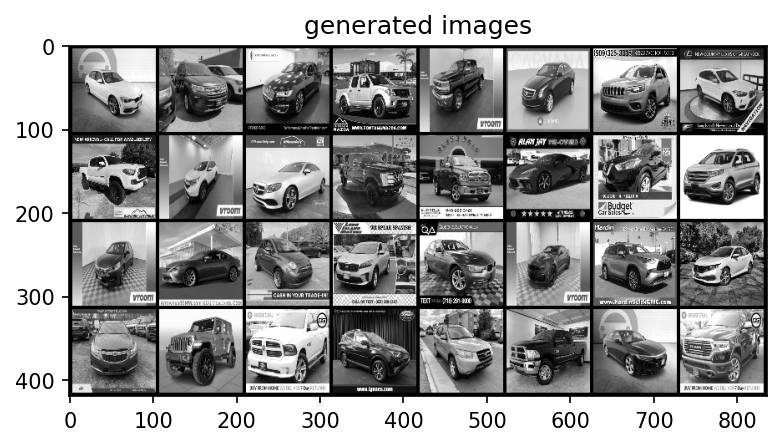

In [8]:
plt.figure(dpi=150)
plt.title('generated images')
plt.imshow(np.transpose(make_grid(batch, padding=4, normalize=True), 
                        (1,2,0)))

In [83]:
#  Building Neural Networks
class Generator(nn.Module):
  def __init__(self, latent_dim=100):
    super().__init__()
    self.latent_dim = latent_dim
    self.linear1 = nn.Linear(latent_dim, 6250)
    self.conv1 = nn.ConvTranspose2d(10, 4, 2, stride=2)
    self.conv2 = nn.ConvTranspose2d(4, 1, 2, stride=2)

  def forward(self, x):
    x = x.view(-1, 1, self.latent_dim)
    x = F.leaky_relu(self.linear1(x), 0,2)
    x = x.view(-1, 10, 25, 25)
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = torch.sigmoid(self.conv2(x))
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 8, 3) 
    self.conv2 = nn.Conv2d(8, 8, 3)
    self.conv3 = nn.Conv2d(8, 16, 3)
    self.conv4 = nn.Conv2d(16, 16, 3)
    self.conv5 = nn.Conv2d(16, 32, 3)
    self.conv6 = nn.Conv2d(32, 64, 3)
    self.pool = nn.MaxPool2d((2,2))
    self.linear1 = nn.Linear(5184, 1500)
    self.linear2 = nn.Linear(1500, 1)

  def forward(self, x):
    x = x.view(-1, 1, 100, 100)
    x = F.leaky_relu(self.conv1(x), 0.2) # 98, 98
    x = self.pool(F.leaky_relu(self.conv2(x), 0.2)) # 48, 48
    x = F.leaky_relu(self.conv3(x), 0.2) # 46, 46
    x = self.pool(F.leaky_relu(self.conv4(x), 0.2)) # 22, 22
    x = F.leaky_relu(self.conv5(x), 0.2) # 20, 20
    x = self.pool(F.leaky_relu(self.conv6(x), 0.2)) # 9, 9
    x = x.view(-1, 5184)
    x = F.leaky_relu(self.linear1(x), 0.2)
    x = self.linear2(x)
    return torch.sigmoid(x)

In [86]:
class GAN(nn.Module):
  def __init__(self, generator, discriminator):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator

  def generator_forward(self, z):
    images = self.generator(z)
    return images

  def discriminator_forward(self, img):
    logits = self.discriminator(img)
    return logits

In [87]:
generator = Generator()
discriminator = Discriminator()

model = GAN(generator, discriminator)
model.to(device)

gen_lr = 2e-4
gen_opt = torch.optim.Adam(model.generator.parameters(), lr=gen_lr, 
                           betas=(0.5, 0.999))

disc_lr = 2e-4
disc_opt = torch.optim.Adam(model.discriminator.parameters(), lr=disc_lr, 
                            betas=(0.5, 0.999))

In [88]:
def train(model=model, dataloader=train_dl, gen_opt=gen_opt, 
          disc_opt=disc_opt, loss_function=None, latent_dim=100, 
          epochs=20):
  
  #  defining log
  log_dict = {
      'generator_loss_per_batch': [],
      'discriminator_loss_per_batch': [],
      'images_from_noise_per_epoch': []
  }

  #  defining loss function
  if loss_function==None:
    loss_function = F.binary_cross_entropy

  #  defining fixed noise for visualisation
  fixed_noise = torch.randn(32, latent_dim, device=device)

  #  instantiating epoch counter
  i=1

  for epoch in range(epochs):
    print(f'Epoch {i}/{len(range(epochs))}')
    model.train()
    for images in tqdm_notebook(dataloader):
      # real images
      real_images = images.to(device)
      real_labels = torch.ones(len(images), device=device)

      #  generated images
      noise = torch.randn(len(images), latent_dim, device=device)
      fake_images = model.generator_forward(noise)
      fake_labels = torch.zeros(len(images), device=device)

      #-------------------------
      # TRAINING DISCRIMINATOR
      #-------------------------
      # real images
      disc_opt.zero_grad()
      disc_preds_real = model.discriminator_forward(real_images)
      real_loss = loss_function(disc_preds_real.view(-1), real_labels)
      
      # fake images
      disc_preds_fake = model.discriminator_forward(fake_images.detach())
      fake_loss = loss_function(disc_preds_fake.view(-1), fake_labels)

      #  combined loss
      disc_loss = 0.5 * (real_loss + fake_loss)
      disc_loss.backward()

      #  adjusting weights
      disc_opt.step()

      #-------------------------
      # TRAINING GENERATOR
      #-------------------------
      gen_opt.zero_grad()
      disc_preds_fake = model.discriminator_forward(fake_images.detach())
      gen_loss = loss_function(disc_preds_fake.view(-1), real_labels)
      gen_loss.backward()
      
      gen_opt.step()

      #-------------------------
      # LOGGING
      #-------------------------
      log_dict['generator_loss_per_batch'].append(gen_loss.item())
      log_dict['discriminator_loss_per_batch'].append(disc_loss.item())

    #  printing loss
    print(f'Generator/Discriminator_Loss: {round(gen_loss.item(), 3)}/{round(disc_loss.item(), 3)}')

    #  producing plots for evaluation
    with torch.no_grad():
      model.eval()
      fake_images = model.generator_forward(fixed_noise).detach().cpu()
      log_dict['images_from_noise_per_epoch'].append(
          make_grid(fake_images, padding=4, normalize=True)
      )

      plt.figure(dpi=150)
      plt.title(f'generated_images | epoch_{i}')
      plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], 
                             (1,2,0)))
      plt.show()

    #  incrementing epoch counter  
    i+=1
  
  return log_dict

Epoch 1/5


  0%|          | 0/2542 [00:00<?, ?it/s]

Generator/Discriminator_Loss: 6.71/0.001


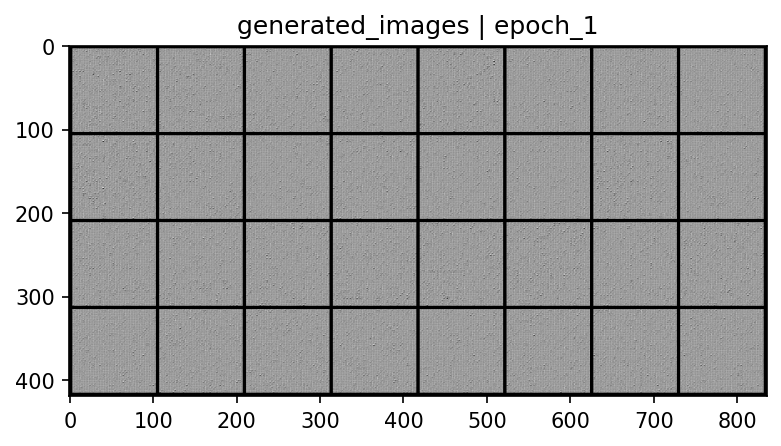

Epoch 2/5


  0%|          | 0/2542 [00:00<?, ?it/s]

Generator/Discriminator_Loss: 10.126/0.0


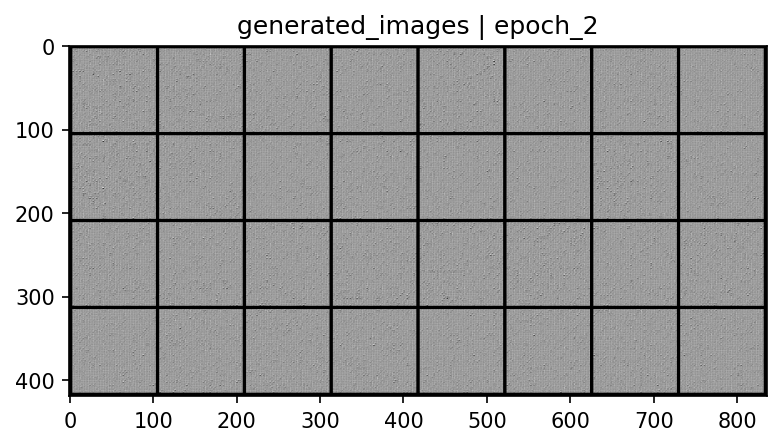

Epoch 3/5


  0%|          | 0/2542 [00:00<?, ?it/s]

Generator/Discriminator_Loss: 10.843/0.0


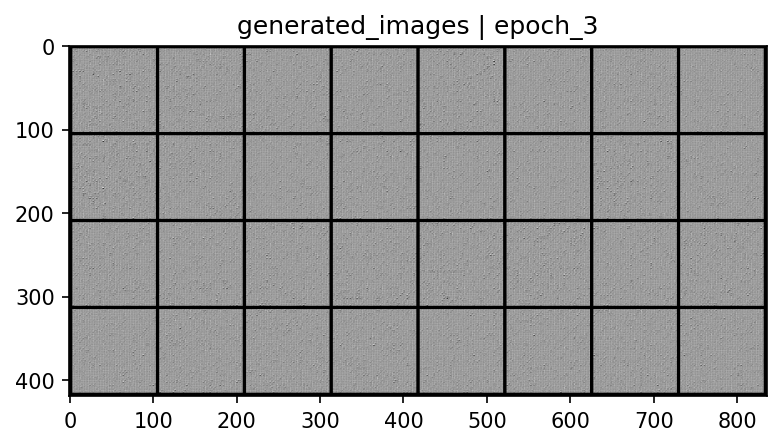

Epoch 4/5


  0%|          | 0/2542 [00:00<?, ?it/s]

Generator/Discriminator_Loss: 14.005/0.0


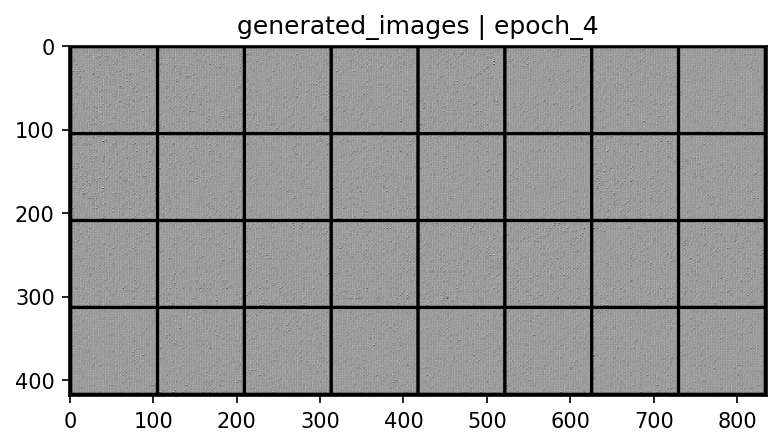

Epoch 5/5


  0%|          | 0/2542 [00:00<?, ?it/s]

Generator/Discriminator_Loss: 0.0/50.0


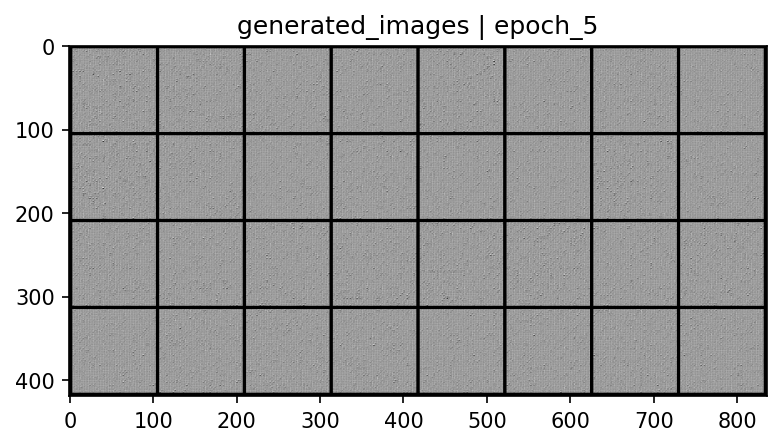

In [89]:
train_log = train(epochs=5)

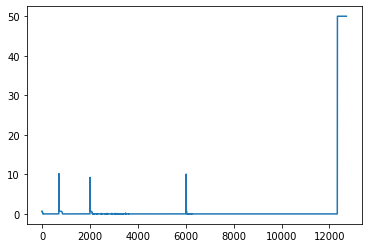

In [103]:
sns.lineplot(y=train_log['discriminator_loss_per_batch'],
             x=np.arange(len(train_log['discriminator_loss_per_batch'])))

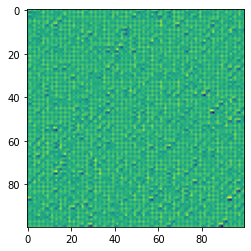

In [90]:
with torch.no_grad():
  plt.imshow(model.generator_forward(torch.randn(100, device=device)).cpu().view(100, 100))